# S3に配置されたCSVファイルをビルトインLightGBMモデルで学習し、バッチ推論する
SageMakerノートブックインスタンスで実行

* インスタンス：ml.r5.8xlarge
* Kernel : conda_python3

# 0.環境確認

In [1]:
!pwd

/home/ec2-user/SageMaker/amazon-sagemaker-examples/introduction_to_amazon_algorithms/lightgbm_catboost_tabular


In [2]:
!uname -a

Linux ip-172-16-5-249.ec2.internal 5.10.157-139.675.amzn2.x86_64 #1 SMP Thu Dec 8 01:29:11 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


In [3]:
!python -V

Python 3.10.8


# 1.サンプルデータ作成し、分割、S3に配置する（ソリューションでは不要）

* 1日1億レコードを想定する
* 学習(train)データとして、1週間(7日間)を想定する。
** 1日1ファイルとする。7ファイルがS3のtrainディレクトリに配置される。
* 評価(valid)データとして、1日を想定する。validディレクトリに配置される。
* テスト(test)データとして、1日を想定する。testディレクトリに配置される。

合計で、7+1+1=9億レコードを初めに生成し、分割してS3に配置する。

## データフォーマットについて

* 1列目が目的変数（ビルトインLightGBMの仕様）
* CSV形式、ヘッダなし

## 1-1. サンプルデータ作成

In [4]:
import pandas as pd
import numpy as np

#num_row = 900000000 # 9日分9億レコード
#num_row = 90000 # テスト用。9日分9万レコード（動作確認用）
num_row = 900 # テスト用。9日分900レコード（動作確認用）

# DataFrameを作成
df = pd.DataFrame({
    'target': np.random.randint(100, 1001, size=num_row),
    'feature_1': np.random.randint(100, 1001, size=num_row),
    'feature_2': np.random.randint(1, 10001, size=num_row),
    'feature_3': np.random.randint(1, 10001, size=num_row),
    'feature_4': np.random.randint(1, 10001, size=num_row),
    'feature_5': np.random.randint(1, 10001, size=num_row),
    'feature_6': np.random.randint(1, 10001, size=num_row),
    'feature_7': np.random.randint(1, 10001, size=num_row),
    'feature_8': np.random.randint(1, 10001, size=num_row),
    'feature_9': np.random.randint(1, 10001, size=num_row),
    'feature_10': np.random.randint(1, 10001, size=num_row),
    'feature_11': np.random.randint(1, 10001, size=num_row),
    'feature_12': np.random.randint(1, 10001, size=num_row),
    'feature_13': np.random.randint(1, 10001, size=num_row),
    'feature_14': np.random.randint(1, 10001, size=num_row),
    'feature_15': np.random.randint(1, 10001, size=num_row),
    'feature_16': np.random.randint(1, 10001, size=num_row),
    'feature_17': np.random.randint(1, 10001, size=num_row),
    'feature_18': np.random.randint(1, 10001, size=num_row),
    'feature_19': np.random.randint(1, 10001, size=num_row),
    'feature_20': np.random.randint(1, 10001, size=num_row),    
})

In [5]:
# Check
print(df.shape)
df.head()

(900, 21)


,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,650,999,6337,4516,5141,8957,4056,1556,4451,5543,...,986,869,3478,3479,642,8955,2592,1949,4219,2281
1,850,331,4486,6472,875,8782,1347,3985,9668,2015,...,6503,5011,5320,4879,3008,394,4861,5425,503,7741
2,430,104,6124,5173,9849,7845,1125,4458,9421,9332,...,2834,7203,1987,3287,5884,7886,1825,837,7571,8673
3,401,794,172,545,769,5808,6382,5973,3524,7090,...,9164,724,7033,706,3355,2887,5479,8750,5223,4977
4,235,909,4152,3815,2136,8185,7315,4390,8935,2856,...,8366,3113,3994,8925,5892,8729,4265,9417,7007,4181


## 1-2. データ分割

In [6]:
yx_tr = df[:int(7 * num_row/9)]
yx_va = df[int(7 * num_row/9):int(8 * num_row/9)]
yx_te = df[int(8 * num_row/9):]

y_te = yx_te.iloc[:, 0]
x_te = yx_te.iloc[:, 1:]

In [7]:
# Check
print(yx_tr.shape)
print(yx_va.shape)
print(yx_te.shape)
print(y_te.shape)
print(x_te.shape)

(700, 21)
(100, 21)
(100, 21)
(100,)
(100, 20)


## 1-3. S3にDataFrameから直接アップロード

https://stackoverflow.com/questions/38154040/save-dataframe-to-csv-directly-to-s3-python

s3://sagemaker-us-east-1-805433377179/analytics_ml/input_sample/

In [8]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
account = sagemaker.Session().account_id()

In [9]:
# Check
print(aws_role)
print(aws_region)
print(sess)
print(account)

arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20230412T165202
us-east-1
805433377179


In [10]:
import s3fs

In [11]:
bucket_name = f'sagemaker-{aws_region}-{account}'
prefix = 'analytics_ml/input_sample'

In [12]:
s3 = s3fs.S3FileSystem(anon=False)

In [13]:
for i in range(1,8):
    print(i)
    filename = f'train_yyyymmdd_{i}.csv'
    with s3.open(f'{bucket_name}/{prefix}/train/{filename}.csv','w') as f:
        yx_tr[int((i-1) * num_row/9):int(i * num_row/9)].to_csv(f, index=False, header=False)

1
2
3
4
5
6
7


In [14]:
i=8
filename = f'valid_yyyymmdd_{i}.csv'
with s3.open(f'{bucket_name}/{prefix}/valid/{filename}.csv','w') as f:
    yx_va.to_csv(f, index=False, header=False)

i=9
filename = f'test_yyyymmdd_{i}.csv'
with s3.open(f'{bucket_name}/{prefix}/test/{filename}.csv','w') as f:
    x_te.to_csv(f, index=False, header=False)

以上の作業は、ソリューションではRedshiftで実施されます。

# 2.ビルトインLightGBMによる学習

https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/lightgbm_catboost_tabular/Amazon_Tabular_Regression_LightGBM_CatBoost.html

## 2-1. コンテナイメージ、ソース、モデルを取得

In [19]:
from sagemaker import image_uris, model_uris, script_uris


train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"

training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

print("============= Container image for training =============")
print(train_image_uri)

=========== Container image for training =============
763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.9.0-cpu-py38


In [16]:
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

print("============= Code for training =============")
print(train_source_uri)

s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/lightgbm/transfer_learning/regression/v2.1.1/sourcedir.tar.gz


In [20]:
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

print("============= pre-trained model of LightGBM =============")
print(train_model_uri)

============= pre-trained model of LightGBM =============
s3://jumpstart-cache-prod-us-east-1/lightgbm-training/train-lightgbm-regression-model.tar.gz


＜確認＞ fine-tuningするの？？

## 2-2. パラメータ設定

In [21]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500"  # The same hyperparameter is named as "iterations" for CatBoost
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


In [22]:
# Sample training data is available in this bucket
training_data_bucket = sess.default_bucket()
training_data_prefix = "analytics_ml/input_sample"
training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/train"
validation_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/valid"
print(training_dataset_s3_path)
print(validation_dataset_s3_path)

s3://sagemaker-us-east-1-805433377179/analytics_ml/input_sample/train
s3://sagemaker-us-east-1-805433377179/analytics_ml/input_sample/valid


In [23]:
output_bucket = sess.default_bucket()
output_prefix = "analytics_ml/output_sample"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output_train"
print(s3_output_location)

s3://sagemaker-us-east-1-805433377179/analytics_ml/output_sample/output_train


In [24]:
s3_output_location

's3://sagemaker-us-east-1-805433377179/analytics_ml/output_sample/output_train'

## 2-3. Estimator定義

In [25]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"{train_model_id}-training")
print(training_job_name)

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

lightgbm-regression-model-training-2023-04-26-01-39-04-281


## 2-4.学習

In [26]:
tabular_estimator.fit(
    {"training" : training_dataset_s3_path,
     "validation" : validation_dataset_s3_path},
    logs=True, 
    job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: lightgbm-regression-model-training-2023-04-26-01-39-04-281


2023-04-26 01:39:15 Starting - Starting the training job...
2023-04-26 01:39:30 Starting - Preparing the instances for training...
2023-04-26 01:40:15 Downloading - Downloading input data...
2023-04-26 01:40:40 Training - Downloading the training image...
2023-04-26 01:41:06 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-26 01:41:14,731 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-26 01:41:14,733 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-26 01:41:14,742 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-26 01:41:14,744 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-26 01:41:15,205 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/o

## 2-5. モデル確認（ソリューションでは不要）

In [27]:
tabular_estimator.model_data

's3://sagemaker-us-east-1-805433377179/analytics_ml/output_sample/output_train/lightgbm-regression-model-training-2023-04-26-01-39-04-281/output/model.tar.gz'

In [28]:
!aws s3 cp $tabular_estimator.model_data .

download: s3://sagemaker-us-east-1-805433377179/analytics_ml/output_sample/output_train/lightgbm-regression-model-training-2023-04-26-01-39-04-281/output/model.tar.gz to ./model.tar.gz


In [29]:
!tar zxvf model.tar.gz

__models_info__.json
model.pkl


In [30]:
import json

# JSONデータが記述されたファイルを開く
with open('__models_info__.json') as f:
    # JSONデータをPythonの辞書オブジェクトに変換
    data = json.load(f)

# 変換されたPythonオブジェクトを表示
print(data)

{'is_trained_on_input_data': True}


# 3.モデルレジストリに登録

後で

# 4. バッチ推論

https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker_batch_transform/batch_transform_associate_predictions_with_input/Batch%20Transform%20-%20breast%20cancer%20prediction%20with%20high%20level%20SDK.ipynb

これは、学習で使ったコンテナイメージをバッチ推論でも利用する場合にはOK.今回は推論時のLightGBMコンテナは異なるのでNG

LightGBMは推論用コンテナ利用なので、
Modelインスタンス作成 -> Transformerインスタンス作成 -> transform()実行。という流れ


https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html#sagemaker.transformer.Transformer


推論結果は、指定したS3に格納される。

<入力ファイル名>.csv.out というファイル名

## 4-1. モデル作成

https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer

これだと学習時と同じコンテナを使うことになるのでNG

モデルには、推論に必要となる以下を定義する

* modelデータの場所
* 推論するコンテナイメージの場所

In [31]:
#sm_transformer = tabular_estimator.transformer(1, "ml.m4.xlarge")
#print(sm_transformer)

https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/lightgbm_catboost_tabular/Amazon_Tabular_Regression_LightGBM_CatBoost.ipynb

In [33]:
# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
print(deploy_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.9.0-cpu-py38


In [34]:
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)
print(deploy_source_uri)

s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/lightgbm/inference/regression/v1.2.0/sourcedir.tar.gz


モデルを作成

https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.Model

学習を実施していない場合は、model_dataにS3のURIを直接渡す。

In [43]:
sm_model = sagemaker.model.Model(deploy_image_uri, 
                                 model_data=tabular_estimator.model_data, # 学習している場合
                                 #model_data=< S3 URI of model>,          # 学習していない場合
                                 role=aws_role, 
                                 predictor_cls=None, 
                                 #env=None,
                                 #name=None, 
                                 #vpc_config=None,
                                 sagemaker_session=sess, 
                                 #enable_network_isolation=None, 
                                 #model_kms_key=None,
                                 #image_config=None, 
                                 source_dir=deploy_source_uri, 
                                 #code_location='inference.py', 
                                 entry_point='inference.py',
                                 #container_log_level=20, 
                                 #dependencies=None,
                                 #git_config=None,
                                )

print(sm_model)

In [39]:
inference_instance_type = "ml.m5.large"

sm_transformer = sm_model.transformer(instance_count=1,
                                      instance_type=inference_instance_type,
                                      #strategy=None,
                                      #assemble_with=None,
                                      #output_path=None,
                                      #output_kms_key=None,
                                      #accept=None,
                                      #env=None,
                                      #max_concurrent_transforms=None,
                                      #max_payload=None,
                                      #tags=None,
                                      #volume_kms_key=None
                                     )
print(sm_transformer)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-26-02-49-12-855


In [40]:
training_data_bucket = sess.default_bucket()
training_data_prefix = "analytics_ml/input_sample"
test_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}/test"
print(test_dataset_s3_path)

s3://sagemaker-us-east-1-805433377179/analytics_ml/input_sample/test


## 4-2. バッチ推論
https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html#sagemaker.transformer.Transformer.transform

<課題>
バッチ推論時間がかかりすぎ？

In [41]:
sm_transformer.transform(test_dataset_s3_path, content_type="text/csv", split_type="Line")
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-jumpstart-2023-04-26-02-49-20-353


..............................Processing /opt/ml/model/code/lib/graphviz/graphviz-0.17-py3-none-any.whl
Processing /opt/ml/model/code/lib/joblib/joblib-1.2.0-py3-none-any.whl
Processing /opt/ml/model/code/lib/lightgbm/lightgbm-3.3.3-py3-none-manylinux1_x86_64.whl
Processing /opt/ml/model/code/lib/plotly/plotly-5.1.0-py2.py3-none-any.whl
Processing /opt/ml/model/code/lib/scikit_learn/scikit_learn-1.0.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Processing /opt/ml/model/code/lib/tenacity/tenacity-8.0.1-py3-none-any.whl
Processing /opt/ml/model/code/lib/threadpoolctl/threadpoolctl-2.2.0-py3-none-any.whl
threadpoolctl is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.

# 5. バッチ推論結果の確認（ソリューションでは不要）
* S3からデータ読み込み
* 真の値と比べる

## 5-1. S3から予測結果をダウンロードし、読み込み

In [44]:
sm_transformer.output_path

's3://sagemaker-us-east-1-805433377179/sagemaker-jumpstart-2023-04-26-02-49-20-353'

In [51]:
local_output_dir = "output_inference"

In [52]:
!aws s3 sync $sm_transformer.output_path $local_output_dir

download: s3://sagemaker-us-east-1-805433377179/sagemaker-jumpstart-2023-04-26-02-49-20-353/test_yyyymmdd_9.csv.csv.out to output_inference/test_yyyymmdd_9.csv.csv.out


In [60]:
df_pred = pd.read_json (local_output_dir + "/test_yyyymmdd_9.csv.csv.out")

In [62]:
# Check
print(df_pred.shape)
df_pred.head()

(100, 1)


,prediction
0,523.273555
1,524.507939
2,522.539238
3,538.170696
4,541.974569


## 5-2. 可視化

In [67]:
# Check
print(df_pred.shape)
print(y_te.shape)

y_te.head()

(100, 2)
(100,)


800    141
801    393
802    698
803    948
804    152
Name: target, dtype: int64

In [68]:
df_pred['ground_truth'] = y_te.values

In [69]:
df_pred

,prediction,ground_truth
0,523.273555,141
1,524.507939,393
2,522.539238,698
3,538.170696,948
4,541.974569,152
...,...,...
95,534.912318,426
96,540.459086,579
97,532.395316,417
98,542.887240,110


<AxesSubplot: >

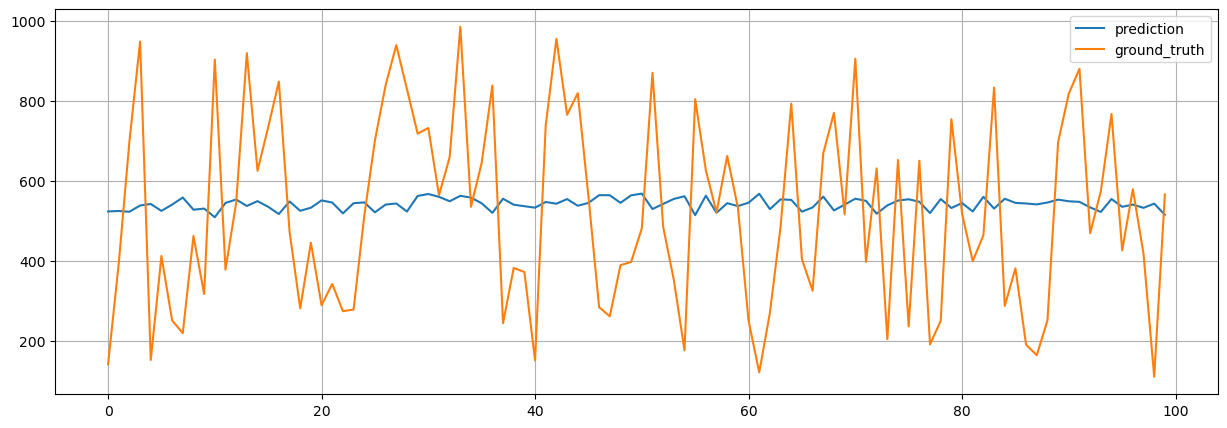

In [77]:
df_pred.plot(grid=True, figsize=(15,5))